In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

from keras.models import Sequential
from keras.layers import Conv2D

import tensorflow as tf
import skimage.metrics
import time

# Setting Parameters

In [2]:
data = 'Bentheimer'

num_classes = 2 # Number of phases
model_list = ['ConvCB'] # Modeling method: ['ConvRF', 'ConvGBM', 'ConvCB', 'ConvXGB', 'ConvLGB']
cluster_i = 'kmeans' # Clustering method: fcmeans, kmeans, agglomerative
train_size = 1 # The number of images for training the model

# Select ground truth (GT) generation approach
GT_gen = 'interactive-based' # Methods: 'cluster-based', 'interactive-based'

# Image size
width = 512
height = 512
n_slices = 100

train_pixels = width*height*train_size # The number of pixels of train image that you want to participate in training
                                       # Choose width*height*train_size if you want all of the pixels of image to participate in training

# Import data

In [3]:
# Load the data
imgs_path = glob.glob('E:/Research/Petroleum/1_Projects/3_UnderRevision/UnderRevision-Image_Segm_Ensemble/Data/{0}/imgs_filtered/'.format(data) + '*.png')
masks_path = glob.glob('E:/Research/Petroleum/1_Projects/3_UnderRevision/UnderRevision-Image_Segm_Ensemble/Data/{0}/masks/'.format(data) + '*.png')
X = []
Y = []
for img in imgs_path:
    image = cv2.imread(img)
    #image = cv2.normalize(image, None, alpha=0,beta=255, norm_type=cv2.NORM_MINMAX)
    X.append(image)

for label in masks_path:
    mask = cv2.imread(label)
    mask2 = mask[:, :, 0]
    mask2 = cv2.normalize(mask2, None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
    #mask = mask/np.max(mask)
    Y.append(mask2)

X = np.asarray(X)
Y = np.asarray(Y)
Y = np.expand_dims(Y, axis = 3) # For having same dimensions as X

# Change the image dimentions
X = X[0:n_slices, 0:width, 0:height, :]
Y = Y[0:n_slices, 0:width, 0:height, :]

# Train-test split

In [4]:
# train_test_split
if len(X) == 1:
    x_train = X.copy()
    x_test = X.copy()
else:
    test_size = len(X) - train_size
    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = train_size, test_size = test_size, random_state=45)  #test_size = 50
    x_test = X.copy()
    y_test = Y.copy()

# Main blocks

In [5]:
# Interactive-based approach
#Crop selected roi from raw image
def ROI(x, space):
    if space == 'pore':
        space_value = 0
    elif space == 'solid':
        space_value = 1
    elif space == 'solid2':
        space_value = 2
    elif space == 'solid3':
        space_value = 3
    elif space == 'solid4':
        space_value = 4
    elif space == 'solid5':
        space_value = 5

    x_ROI = []
    # Select ROIs
    ROIs = cv2.selectROIs("Select ROIs", x)
    #counter to save image with different name
    crop_number=0 
    #loop over every bounding box save in array "ROIs"
    for rect in ROIs:
        x1=rect[0]
        y1=rect[1]
        x2=rect[2]
        y2=rect[3]
        #crop roi from original image
        ROI_crop=x_train[0][y1:y1+y2,x1:x1+x2]
        # Resize the crops
        ROI_crop_resized = cv2.resize(ROI_crop, (width, height))
        #show cropped image
        cv2.imshow("crop"+str(crop_number),ROI_crop_resized)
        #save cropped image
        #cv2.imwrite("crop"+str(crop_number)+".jpeg",pore_crop)       
        crop_number+=1
        x_ROI.append(ROI_crop_resized)
    x_ROI = np.asarray(x_ROI)
    y_ROI = x_ROI.copy()
    y_ROI[:] = space_value
    #hold window
    cv2.waitKey(0)
    return x_ROI, y_ROI

In [6]:
# Cluster-based approach
def clustering(num_classes, x):
    k = num_classes #number of clusters
    if cluster_i == 'kmeans':
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.2) # define stopping criteria
        _, labels, (centers) = cv2.kmeans(x, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        # convert back to 8 bit values
        centers = np.uint8(centers)
        
    elif cluster_i == 'agglomerative':
        from sklearn.cluster import AgglomerativeClustering
        cl = AgglomerativeClustering(n_clusters=k, linkage= 'ward') # linkage{‘ward’, ‘complete’, ‘average’, ‘single’}
        cl.fit(x)
        labels = cl.labels_
    elif cluster_i == 'fcmeans':
        from fcmeans import FCM
        model = FCM(n_clusters=k) # we use two cluster as an example
        model.fit(x) ## X, numpy array. rows:samples columns:features
        centers = model.centers
        labels = model.predict(x)
        
    # flatten the labels array
    labels = labels.flatten()

    return labels

In [7]:
# Feature extraction
def feature_extraction(x_train, x_test):
    activation = 'relu'
    feature_extractor = Sequential()
    feature_extractor.add(Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same', input_shape=(width, height, 3)))
    feature_extractor.add(Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same', kernel_initializer='he_uniform'))

    feature_extractor.summary()
    x_train_features = feature_extractor.predict(x_train, batch_size=1)
    x_test_features = feature_extractor.predict(x_test, batch_size=1)
    return x_train_features, x_test_features

In [8]:
# Modeling
def modeling (model_i, x_train, y_train):
    if model_i == 'ConvRF':
        model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
    elif model_i == 'ConvGBM':
        model = GradientBoostingClassifier(n_estimators=50,
                          learning_rate = 0.3,
                          max_depth=3,
                          subsample=1,
                          #loss='ls'
                          )
    elif model_i == 'ConvCB':
        model = CatBoostClassifier(n_estimators=50,
                          learning_rate = 0.3,
                          max_depth=3,
                          #task_type="GPU"
                          )
    elif model_i == 'ConvXGB':
        model = XGBClassifier(n_estimators=50,
                          learning_rate = 0.3,
                          max_depth=3,
                          booster = 'gbtree',
                          eta=0.3,
                          gamma = 0,
                          alpha = 0.15,
                          nthread=4,
                          subsample=1,
                          colsample_bytree=0.8,
                          colsample_bylevel = 1,
                          sketch_eps = 0.03,
                          scale_pos_weight= 1,
                          objective = 'count:poisson',
                          ) # For running on GPU: tree_method='gpu_hist', gpu_id=0
    elif model_i == 'ConvLGB':
        model = lgb.LGBMClassifier(boosting_type = 'dart',
                                n_estimators = 50,
                                learning_rate = 0.1,
                                max_depth = 3,
                                random_state = 1) # For running on GPU: device='gpu'
    elif model_i == 'RF':
        model = RandomForestClassifier(n_estimators=50, random_state=42)

    elif model_i == 'GBM':
        model = GradientBoostingClassifier(n_estimators=50,
                          learning_rate = 0.3,
                          max_depth=3,
                          subsample=1,
                          #loss='ls'
                          )
    elif model_i == 'XGB':
        model = XGBClassifier(n_estimators=50,
                          learning_rate = 0.3,
                          max_depth=3,
                          eta=0.3,
                          gamma = 0,
                          alpha = 0.15,
                          nthread=4,
                          subsample=1,
                          colsample_bytree=0.8,
                          colsample_bylevel = 1,
                          sketch_eps = 0.03,
                          scale_pos_weight= 1
                          ) # For running on GPU: tree_method='gpu_hist', gpu_id=0
    elif model_i == 'LGB':
        model = lgb.LGBMClassifier(boosting_type = 'dart',
                                n_estimators = 50,
                                learning_rate = 0.1,
                                max_depth = 3,
                                random_state = 1) # For running on GPU: device='gpu'

    model.fit(x_train, y_train)
    return model

In [9]:
# Evaluation 
def eval(y_pred, y):
    # Model Evaluation
    acc = metrics.accuracy_score(y_pred, y)
    f1_score = metrics.f1_score(y_pred, y)
    iou = metrics.jaccard_score(y_pred, y)
    psnr = skimage.metrics.peak_signal_noise_ratio(y_pred, y)
    ssim = skimage.metrics.structural_similarity(y_pred, y)
       
    return acc, f1_score, iou, psnr, ssim

# GT generation (Cluster-based and Interactive-based)

In [10]:
if GT_gen == 'cluster-based':
    x_train_reshaped = x_train.reshape(-1, x_train.shape[3])
    # Generate GT data using k-means clustering
    y_true = clustering(num_classes, np.float32(x_train_reshaped))

    y_pred_cluster = y_true.reshape(y_test[0].shape)
    print(y_pred_cluster.shape)

elif GT_gen == 'interactive-based':
    # Select pores
    x_ROI_pore, y_ROI_pore = ROI(x_train[0], space ='pore')
    print(x_ROI_pore.shape, y_ROI_pore.shape)

    x_ROI_solid, y_ROI_solid = ROI(x_train[0], space ='solid')
    print(x_ROI_solid.shape, y_ROI_solid.shape)

    if num_classes == 2:
        x_ROI_train= np.concatenate((x_ROI_pore, x_ROI_solid))
        y_ROI_train= np.concatenate((y_ROI_pore, y_ROI_solid))

    if num_classes >= 3:
        x_ROI_solid2, y_ROI_solid2 = ROI(x_train[0], space ='solid2')
        print(x_ROI_solid2.shape, y_ROI_solid2.shape)
        if num_classes ==3:
            x_ROI_train= np.concatenate((x_ROI_pore, x_ROI_solid, x_ROI_solid2))
            y_ROI_train= np.concatenate((y_ROI_pore, y_ROI_solid, y_ROI_solid2))
    if num_classes >= 4:
        x_ROI_solid3, y_ROI_solid3 = ROI(x_train[0], space ='solid3')
        print(x_ROI_solid3.shape, y_ROI_solid3.shape)
        if num_classes == 4:
            x_ROI_train= np.concatenate((x_ROI_pore, x_ROI_solid, x_ROI_solid2, x_ROI_solid3))
            y_ROI_train= np.concatenate((y_ROI_pore, y_ROI_solid, y_ROI_solid2, y_ROI_solid3))
    if num_classes >= 5:
        x_ROI_solid4, y_ROI_solid4 = ROI(x_train[0], space ='solid4')
        print(x_ROI_solid4.shape, y_ROI_solid4.shape)
        if num_classes == 5:
            x_ROI_train= np.concatenate((x_ROI_pore, x_ROI_solid, x_ROI_solid2, x_ROI_solid3, x_ROI_solid4))
            y_ROI_train= np.concatenate((y_ROI_pore, y_ROI_solid, y_ROI_solid2, y_ROI_solid3, y_ROI_solid4))

    if num_classes >= 6:
        x_ROI_solid5, y_ROI_solid5 = ROI(x_train[0], space ='solid3')
        print(x_ROI_solid5.shape, y_ROI_solid5.shape)
        if num_classes == 6:
            x_ROI_train= np.concatenate((x_ROI_pore, x_ROI_solid, x_ROI_solid2, x_ROI_solid3, x_ROI_solid4, x_ROI_solid5))
            y_ROI_train= np.concatenate((y_ROI_pore, y_ROI_solid, y_ROI_solid2, y_ROI_solid3, y_ROI_solid4, y_ROI_solid5))

    x_ROI_train_reshaped = x_ROI_train.reshape(-1, x_ROI_train.shape[3])
    y_ROI_train_reshaped = y_ROI_train[:, :, :, 0].reshape(-1)
    print(x_ROI_train.shape, y_ROI_train.shape)
    print(x_ROI_train_reshaped.shape, y_ROI_train_reshaped.shape)

    # modeling
    x_train_reshaped = x_train.reshape(-1, x_train.shape[3])

    ROI_model = modeling('LGB', x_ROI_train_reshaped, y_ROI_train_reshaped)
    y_true = ROI_model.predict(x_train_reshaped)

    y_pred_cluster = y_true.reshape(y_test[0].shape)
    print(y_pred_cluster.shape)


(3, 512, 512, 3) (3, 512, 512, 3)
(3, 512, 512, 3) (3, 512, 512, 3)
(6, 512, 512, 3) (6, 512, 512, 3)
(1572864, 3) (1572864,)
(512, 512, 1)


In [11]:
start0 = time.time()
# Extract Features for x_train and x_test data
with tf.device('/CPU:0'):
    x_train_cnn, x_test_cnn = feature_extraction(x_train, x_test)
# Reshape
x_train_cnn_reshaped = x_train_cnn.reshape(-1, x_train_cnn.shape[3])
x_test_cnn_reshaped = x_test_cnn.reshape(-1, x_test_cnn.shape[3])
y_train_cnn_reshaped = y_train.reshape(-1)
y_test_cnn_reshaped = y_test.reshape(-1)

end0 = time.time()
elapsed_time0 = end0-start0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      9248      
                                                                 
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________
100/100 [==============================] - 3s 27ms/step


In [13]:
# Train the model
for model_i in model_list:
    start = time.time() 
    #y_true = clustering(num_classes, x_train_cnn_reshaped[0:train_pixels])
    model = modeling(model_i , x_train_cnn_reshaped, y_true)
    #model = modeling(model_i , x_train_cnn_reshaped, y_true)
    # Segment using trained model
    y_train_pred = model.predict(x_train_cnn_reshaped)
    y_test_pred = model.predict(x_test_cnn_reshaped)

    end = time.time()
    elapsed_time = elapsed_time0 + (end-start)
    print('Elapsed time', elapsed_time)
 
    # Check if the prediction and GT labels are different
    if num_classes ==2:
        count_zero = np.count_nonzero(y_test_pred == 0) # Count the number of zeros
        count_one = np.count_nonzero(y_test_pred == 1) # Count the number of ones
        if count_zero > count_one: # The number of voids are lower than solid pixels. We want to label voids by black (0) and solids by white (1). 
            y_train_pred = np.invert(y_train_pred)
            y_train_pred = cv2.normalize(y_train_pred, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            y_train_pred = y_train_pred[:, 0]

            y_test_pred = np.invert(y_test_pred)
            y_test_pred = cv2.normalize(y_test_pred, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            y_test_pred = y_test_pred[:, 0]
            print ("Labels are not consistant. We changed them.")
        else:
            print ("Labels are consistant")

    # Evaluate the model
    acc_train, f1_train, iou_train, psnr_train, ssim_train = eval(y_train_pred, y_train_cnn_reshaped)
    acc_test, f1_test, iou_test, psnr_test, ssim_test = eval(y_test_pred, y_test_cnn_reshaped)

    print ('Train score', acc_train, f1_train, iou_train, psnr_train, ssim_train)
    print ('Test score', acc_test, f1_test, iou_test, psnr_test, ssim_test)
    '''
    # Save results
    import csv
    header = ['Model', 'Accuracy', 'f1-score', 'IOU', 'PSNR', 'SSIM', 'Time (s)']
    scores = [['Train', acc_train, f1_train, iou_train, psnr_train, ssim_train, elapsed_time],
            ['Test', acc_test, f1_test, iou_test, psnr_test, ssim_test, elapsed_time],
            ]

    with open('outputs/pred_scores/Scores.{0}.{1}.csv'.format(data, model_i), 'w') as file_writer:
        writer = csv.writer(file_writer)

        writer.writerow(header)
        for item in scores:
            writer.writerow(item)
    '''
    # Reshape for visualizing
    y = y_test_cnn_reshaped.reshape(y_test.shape)
    y_pred = y_test_pred.reshape(y_test.shape)

0:	learn: 0.1394586	total: 21.2ms	remaining: 1.04s
1:	learn: 0.0601971	total: 36.7ms	remaining: 881ms
2:	learn: 0.0292991	total: 52.4ms	remaining: 822ms
3:	learn: 0.0245874	total: 68ms	remaining: 782ms
4:	learn: 0.0215463	total: 83.3ms	remaining: 750ms
5:	learn: 0.0206699	total: 97.6ms	remaining: 716ms
6:	learn: 0.0193846	total: 112ms	remaining: 687ms
7:	learn: 0.0183401	total: 125ms	remaining: 659ms
8:	learn: 0.0175609	total: 140ms	remaining: 638ms
9:	learn: 0.0172094	total: 154ms	remaining: 616ms
10:	learn: 0.0166551	total: 169ms	remaining: 599ms
11:	learn: 0.0163014	total: 186ms	remaining: 588ms
12:	learn: 0.0158735	total: 203ms	remaining: 577ms
13:	learn: 0.0151713	total: 218ms	remaining: 560ms
14:	learn: 0.0146195	total: 233ms	remaining: 543ms
15:	learn: 0.0143493	total: 250ms	remaining: 531ms
16:	learn: 0.0142043	total: 270ms	remaining: 523ms
17:	learn: 0.0139975	total: 288ms	remaining: 511ms
18:	learn: 0.0137787	total: 305ms	remaining: 497ms
19:	learn: 0.0135582	total: 324ms	rem

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_8904\5743316.py:7: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage.metrics.peak_signal_noise_ratio(y_pred, y)
c:\Users\Microsoft\anaconda3\envs\tf-gpu\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
C:\Users\Microsoft\AppData\Local\Temp\ipykernel_8904\5743316.py:7: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage.metrics.peak_signal_noise_ratio(y_pred, y)
c:\Users\Microsoft\anaconda3\envs\tf-gpu\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Train score 0.9688987731933594 0.9784383471074379 0.9577868788799776 394.3700193328926 1.0
Test score 0.9732926559448242 0.9820335408018491 0.9647012747113437 395.03148752444196 1.0


In [14]:
print(y_test_cnn_reshaped.shape)
print(y_test_pred.shape)
print(y_test.shape)

y = y_test_cnn_reshaped.reshape(y_test.shape)
y_pred = y_test_pred.reshape(y_test.shape)

print(y.shape)
print(y_pred.shape)

(26214400,)
(26214400,)
(100, 512, 512, 1)
(100, 512, 512, 1)
(100, 512, 512, 1)


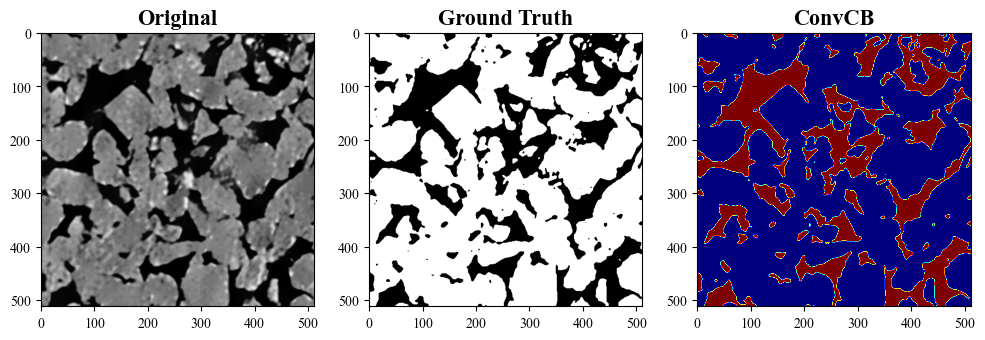

In [15]:
i = 0

plt.rcParams["font.family"] = "Times New Roman"
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }
plt.figure(figsize=[12, 4])
plt.subplot(1, 3, 1)
plt.imshow(x_test[i], cmap='gray')
plt.title('Original', fontdict=font)
plt.subplot(1, 3, 2)
plt.imshow(y[i], cmap ='gray')
plt.title('Ground Truth', fontdict=font)
plt.subplot(1, 3, 3)
plt.imshow(y_pred[i], cmap ='jet_r')
plt.title('{0}'.format(model_i), fontdict=font)
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
#plt.savefig('*.svg', dpi=900)
#plt.savefig('*.png', dpi=900)
plt.show()